In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import initializers
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = 28
NUM_CLASSES = 10
NUM_CHANNELS = 1
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_weight_init"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(x_test), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(y_test, axis=1))

# Train

In [11]:
models = []
accuracies = [0]
initializer = ["Zero","Ones","Random Normal","Random Uniform","Identity","Orthogonal","Glorot Normal","Glorot Uniform"]
for i in range(len(initializer)):

    print(f"Train model {i}")
    print(f"Weight init method: {initializer[i]} ")
    model = FashionMNISTmodel(IMAGE_SIZE,NUM_CLASSES,NUM_CHANNELS)
    
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            if(initializer[i] == "Zero"):
                layer.kernel_initializer = initializers.Zeros()
            elif(initializer[i] == "Ones"):
                layer.kernel_initializer = initializers.Ones()
            elif(initializer[i] == "Random Normal"):
                layer.kernel_initializer = initializers.RandomNormal()
            elif(initializer[i] == "Random Unifrom"):
                layer.kernel_initializer = initializers.RandomUniform()
            elif(initializer[i] == "Identity"):
                layer.kernel_initializer = initializers.Identity()
            elif(initializer[i] == "Orthogonal"):
                layer.kernel_initializer = initializers.Orthogonal()
            elif(initializer[i] == "Glorot Normal"):
                layer.kernel_initializer = initializers.GlorotNormal()
            elif(initializer[i] == "Glorot Unifrom"):
                layer.kernel_initializer = initializers.GlorotUnifrom()
          
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=0.01, patience=3)
    model.fit(x_train,y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_test,y_test),
              shuffle = True,
              callbacks=[es])
    models.append(model)

    acc = predict(models)

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")


Train model 0
Weight init method: Zero 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 10s 203us/step - loss: 2.1487 - accuracy: 0.2455 - val_loss: 2.1708 - val_accuracy: 0.2841
Epoch 2/20
 2432/48000 [>.............................] - ETA: 3s - loss: 1.9953 - accuracy: 0.3573

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


48000/48000 [==============================] - 4s 76us/step - loss: 1.8997 - accuracy: 0.3768 - val_loss: 1.8102 - val_accuracy: 0.4124
Epoch 3/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.7049 - accuracy: 0.4332 - val_loss: 1.6138 - val_accuracy: 0.4573
Epoch 4/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.5538 - accuracy: 0.4789 - val_loss: 1.4793 - val_accuracy: 0.5064
Epoch 5/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.4304 - accuracy: 0.5273 - val_loss: 1.3724 - val_accuracy: 0.5483
Epoch 6/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.3392 - accuracy: 0.5654 - val_loss: 1.2922 - val_accuracy: 0.5834
Epoch 7/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.2675 - accuracy: 0.5879 - val_loss: 1.2317 - val_accuracy: 0.6032
Epoch 8/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.2105 - accuracy: 0.6040 - val_loss: 1.1830 - val

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Model: 0 added. Resulting score: 0.684
Train model 1
Weight init method: Ones 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 82us/step - loss: 2.2546 - accuracy: 0.2019 - val_loss: 2.2334 - val_accuracy: 0.3373
Epoch 2/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.9715 - accuracy: 0.3614 - val_loss: 1.8556 - val_accuracy: 0.4184
Epoch 3/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.7264 - accuracy: 0.4407 - val_loss: 1.6146 - val_accuracy: 0.4839
Epoch 4/20
48000/48000 [==============================] - 4s 78us/step - loss: 1.5381 - accuracy: 0.5052 - val_loss: 1.4571 - val_accuracy: 0.5396
Epoch 5/20
48000/48000 [==============================] - 4s 82us/step - loss: 1.4011 - accuracy: 0.5479 - val_loss: 1.3431 - val_accuracy: 0.5672
Epoch 6/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.3037 - accuracy: 0.5785 - val_loss: 1.2626 - val_accura

100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Model: 1 added. Resulting score: 0.6987
Train model 2
Weight init method: Random Normal 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 82us/step - loss: 2.1713 - accuracy: 0.1981 - val_loss: 2.1893 - val_accuracy: 0.3017
Epoch 2/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.8716 - accuracy: 0.4382 - val_loss: 1.7423 - val_accuracy: 0.4626
Epoch 3/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.6188 - accuracy: 0.4941 - val_loss: 1.5204 - val_accuracy: 0.5150
Epoch 4/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.4609 - accuracy: 0.5376 - val_loss: 1.3975 - val_accuracy: 0.5486
Epoch 5/20
48000/48000 [==============================] - 4s 74us/step - loss: 1.3521 - accuracy: 0.5684 - val_loss: 1.3043 - val_accuracy: 0.5802
Epoch 6/20
48000/48000 [==============================] - 4s 74us/step - loss: 1.2705 - accuracy: 0.5914 - val_loss: 1.2318 - 

100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Model: 2 added. Resulting score: 0.717
Train model 3
Weight init method: Random Unifrom 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 81us/step - loss: 2.1491 - accuracy: 0.2372 - val_loss: 2.1718 - val_accuracy: 0.3124
Epoch 2/20
48000/48000 [==============================] - 4s 74us/step - loss: 1.8905 - accuracy: 0.4095 - val_loss: 1.7846 - val_accuracy: 0.4421
Epoch 3/20
48000/48000 [==============================] - 4s 74us/step - loss: 1.6600 - accuracy: 0.4795 - val_loss: 1.5538 - val_accuracy: 0.5004
Epoch 4/20
48000/48000 [==============================] - 4s 74us/step - loss: 1.4873 - accuracy: 0.5284 - val_loss: 1.4132 - val_accuracy: 0.5571
Epoch 5/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.3679 - accuracy: 0.5661 - val_loss: 1.3173 - val_accuracy: 0.5773
Epoch 6/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.2830 - accuracy: 0.5864 - val_loss: 1.2463 - 

100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Model: 3 added. Resulting score: 0.7118
Train model 4
Weight init method: Identity 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 84us/step - loss: 2.1553 - accuracy: 0.2131 - val_loss: 2.1742 - val_accuracy: 0.2281
Epoch 2/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.8659 - accuracy: 0.3871 - val_loss: 1.7598 - val_accuracy: 0.4280
Epoch 3/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.6311 - accuracy: 0.4780 - val_loss: 1.5296 - val_accuracy: 0.5047
Epoch 4/20
48000/48000 [==============================] - 4s 78us/step - loss: 1.4639 - accuracy: 0.5305 - val_loss: 1.3891 - val_accuracy: 0.5523
Epoch 5/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.3457 - accuracy: 0.5679 - val_loss: 1.2935 - val_accuracy: 0.5817
Epoch 6/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.2604 - accuracy: 0.5893 - val_loss: 1.2186 - val_a

100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Model: 4 added. Resulting score: 0.7145
Train model 5
Weight init method: Orthogonal 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 82us/step - loss: 2.2271 - accuracy: 0.2100 - val_loss: 2.2119 - val_accuracy: 0.1924
Epoch 2/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.9787 - accuracy: 0.4407 - val_loss: 1.8755 - val_accuracy: 0.4601
Epoch 3/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.7214 - accuracy: 0.4897 - val_loss: 1.5990 - val_accuracy: 0.5052
Epoch 4/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.5135 - accuracy: 0.5258 - val_loss: 1.4285 - val_accuracy: 0.5496
Epoch 5/20
48000/48000 [==============================] - 4s 82us/step - loss: 1.3808 - accuracy: 0.5615 - val_loss: 1.3201 - val_accuracy: 0.5882
Epoch 6/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.2868 - accuracy: 0.5920 - val_loss: 1.2424 - val

100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Model: 5 added. Resulting score: 0.7177
Train model 6
Weight init method: Glorot Normal 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 83us/step - loss: 2.1850 - accuracy: 0.2416 - val_loss: 2.1911 - val_accuracy: 0.3165
Epoch 2/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.9054 - accuracy: 0.3821 - val_loss: 1.7935 - val_accuracy: 0.4465
Epoch 3/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.6647 - accuracy: 0.4481 - val_loss: 1.5595 - val_accuracy: 0.4838
Epoch 4/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.4961 - accuracy: 0.5094 - val_loss: 1.4239 - val_accuracy: 0.5352
Epoch 5/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.3773 - accuracy: 0.5587 - val_loss: 1.3249 - val_accuracy: 0.5745
Epoch 6/20
48000/48000 [==============================] - 4s 77us/step - loss: 1.2919 - accuracy: 0.5818 - val_loss: 1.2521 - 

100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Model: 6 added. Resulting score: 0.7144
Train model 7
Weight init method: Glorot Uniform 
Train on 48000 samples, validate on 10000 samples
Epoch 1/20
48000/48000 [==============================] - 4s 82us/step - loss: 2.1557 - accuracy: 0.2471 - val_loss: 2.1867 - val_accuracy: 0.3487
Epoch 2/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.8822 - accuracy: 0.4099 - val_loss: 1.7901 - val_accuracy: 0.4467
Epoch 3/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.6593 - accuracy: 0.4705 - val_loss: 1.5631 - val_accuracy: 0.5091
Epoch 4/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.4958 - accuracy: 0.5174 - val_loss: 1.4264 - val_accuracy: 0.5545
Epoch 5/20
48000/48000 [==============================] - 4s 76us/step - loss: 1.3793 - accuracy: 0.5612 - val_loss: 1.3258 - val_accuracy: 0.5750
Epoch 6/20
48000/48000 [==============================] - 4s 75us/step - loss: 1.2909 - accuracy: 0.5936 - val_loss: 1.2487 -

100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

Model: 7 added. Resulting score: 0.7195


# Results

# Accuracy

In [25]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
initializer.insert(0, "None")
accuracy_df["weight_init_method"] = initializer
display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,weight_init_method
0,0.0000,None
1,0.6840,Zero
2,0.6987,Ones
3,0.7170,Random Normal
4,0.7118,Random Unifrom
5,0.7145,Identity
6,0.7177,Orthogonal
7,0.7144,Glorot Normal
8,0.7195,Glorot Uniform


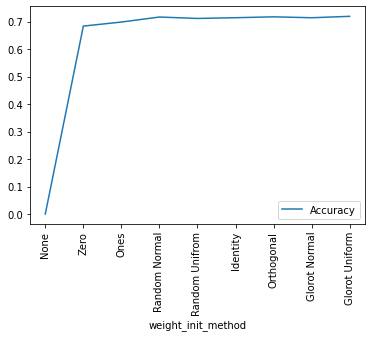

In [41]:
import matplotlib.pyplot as plt

accuracy_df.plot(x="weight_init_method", y="Accuracy",rot = 90)

plt.show()

## Correlation between models

In [42]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


In [43]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2,3,4,5,6,7
0,NaN,0.871305,0.875581,0.870748,0.888393,0.874177,0.871880,0.867839
1,0.871305,NaN,0.899659,0.863129,0.891148,0.897952,0.877635,0.883685
2,0.875581,0.899659,NaN,0.859124,0.885291,0.889631,0.870224,0.885219
3,0.870748,0.863129,0.859124,NaN,0.879595,0.871862,0.894571,0.857108
4,0.888393,0.891148,0.885291,0.879595,NaN,0.893063,0.881699,0.881690
5,0.874177,0.897952,0.889631,0.871862,0.893063,NaN,0.900322,0.891488
6,0.871880,0.877635,0.870224,0.894571,0.881699,0.900322,NaN,0.864986
7,0.867839,0.883685,0.885219,0.857108,0.881690,0.891488,0.864986,NaN


Average correlation: 0.8799643988209123
